# Figure 4, panels a-d, g-j, and Supplementary Figure 3, panel b
Visium H&E dataset image analysis
- cell segmentation using stardist
- summary feature calculation + cell density
- comparison with gene clusters
- spatially variable genes

In [1]:
import scanpy as sc
import squidpy as sq

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

import skimage.exposure

In [2]:
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

## Prepare segmentation, features, and clusters
save calculate features and segmentation for later use

### cell segmentation using stardist

In [3]:
# Import the StarDist 2D segmentation models.
from stardist.models import StarDist2D 
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize

# Import squidpy and additional packages needed for this tutorial.
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

import dask
# use only one thread, multiple does not seem to work well with tf / keras
dask.config.set(scheduler='synchronous')

# load pretrained stardist model
StarDist2D.from_pretrained('2D_versatile_he')

# custom segmentation function
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [255]:
# smooth image
sq.im.process(img, layer="image", method="smooth", sigma=3)
img.compute()

ImageContainer[shape=(11757, 11291), layers=['image', 'image_smooth', 'segmented_stardist']]

In [7]:
# segment using lower prob_thresh value to capture all cells
sq.im.segment(
    img=img, 
    layer="image_smooth", 
    channel=None,
    method=stardist_2D_versatile_he, 
    layer_added='segmented_stardist', 
    prob_thresh=0.3,
    nms_thresh=0.5,
    chunks=5000,
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found

In [8]:
# save image
img.save('data/visium_hne_image_segmented.zarr')

### calculate features: segmentation and summary

In [271]:
# custom feature extraction function
def segmentation_feature(seg):
    """ fraction of area covered by cells, number of cells"""
    num_segments = len(np.unique(seg))-1
    area = (seg != 0).sum() / seg.size
    return area, num_segments

In [272]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    'features_orig': 
    {'features': 'summary',
     'layer': 'image',
    'spot_scale': 1,
    'scale': 1.0,
    'mask_circle': True},
    # summary and histogram features with a bit more context, original resolution
    'features_context': 
    {'features': 'summary',
     'layer': 'image',
    'spot_scale': 2,
    'scale': 1.0},
    # summary and histogram features with more context and at lower resolution
    'features_lowres' :
    {'features': 'summary',
     'layer': 'image',
    'spot_scale': 4,
    'scale': 0.25},
    # segmentation features: area of tissue covered by cells
    'features_segmentation':
    {'features': 'custom',
     'layer': 'segmented_stardist',
    'spot_scale': 2,
    'scale': 1.0,
    'features_kwargs':{'custom':{'func':segmentation_feature}}},
}

In [273]:
# extract features with the different parameters in a loop
for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    if 'segmentation' not in feature_name:
        continue
    sq.im.calculate_image_features(adata, img, key_added=feature_name, n_jobs=4, **cur_params)

  0%|          | 0/2688 [00:00<?, ?/s]

In [92]:
# fill nans
adata.obsm['features_orig'].fillna(value=0, inplace=True)
# combine features in one dataframe
adata.obsm['features'] = pd.concat([adata.obsm[f] for f in ['features_orig', 'features_context', 'features_lowres']], axis='columns')
# make sure that we have no duplicated feature names in the combined table
adata.obsm['features'].columns = ad.utils.make_index_unique(adata.obsm['features'].columns)

In [153]:
# helper function returning a clustering
def cluster_features(features, like=None):
    """Calculate leiden clustering of features.
    
    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1]-1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    
    return adata.obs['leiden']

In [261]:
# cluster features
adata.obs['features_cluster'] = cluster_features(adata.obsm['features'])

# additionally, cluster segmentation features & all features -> but overall layout of clusters does not change
#adata.obs['features_cluster_seg'] = cluster_features(adata.obsm['features_segmentation'])
#adata.obs['features_cluster_all'] = cluster_features(pd.concat([adata.obsm['features_segmentation'], 
#                                                                adata.obsm['features']], axis='columns'))

In [274]:
# save features clusters to always have the same clusters
#adata.obs['features_cluster'].to_csv('data/features_cluster.csv')

adata.obsm['features_segmentation'].to_csv('data/features_segmentation.csv')

## Plot and save figs

In [3]:
img = sq.im.ImageContainer.load('data/visium_hne_image_segmented.zarr')

# load features clusters in adata
adata.obs['features_cluster'] = pd.read_csv('data/features_cluster.csv', index_col=0)
adata.obs['features_cluster'] = adata.obs['features_cluster'].astype('category')

adata.obsm['features_segmentation'] = pd.read_csv('data/features_segmentation.csv', index_col=0)

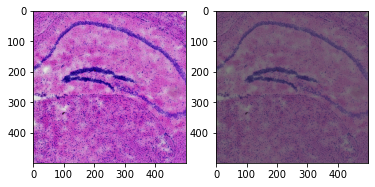

In [4]:
# make hne image a bit brighter
#img_png = adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires']
p2, p98 = np.percentile(img_png, (0.5, 99.5))
img_rescale = skimage.exposure.rescale_intensity(img_png, in_range=(p2, p98))

fig, axes = plt.subplots(1,2)
axes[0].imshow(img_rescale[500:1000,500:1000])
axes[1].imshow(img_png[500:1000,500:1000])

adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires'] = img_rescale

In [5]:
# plotting settings
sc.settings.dpi = 300
sc.set_figure_params(facecolor="white", fontsize=14)
# fontsize sets the size of the title

... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


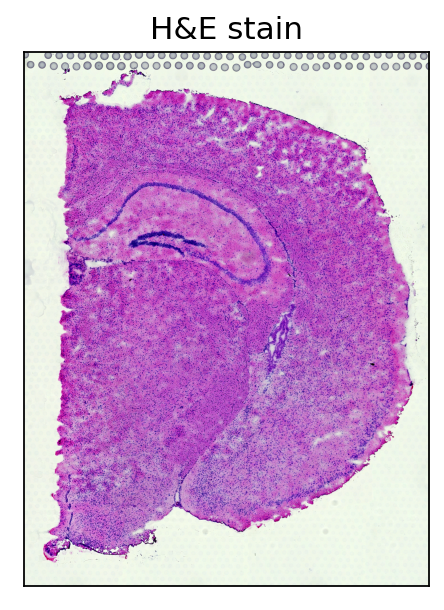

In [322]:
# plot hne
fig, ax = plt.subplots(
    figsize=(3, 5),
)
sc.pl.spatial(
    adata,
    color=None,
    img_key='hires',
    ax=ax,
    title='H&E stain',
    #legend_loc=False,
    show=False
)
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# save figure
plt.tight_layout()
plt.savefig('figures/hne/spatial_hne.png', dpi=300, bbox_inches='tight')

... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


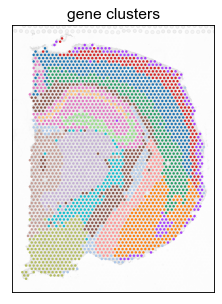

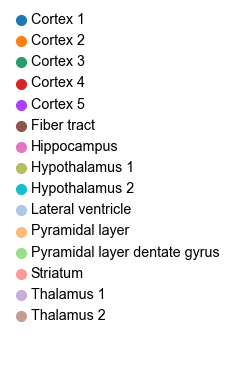

In [7]:
# plot gene clusters
fig, ax = plt.subplots(figsize=(3, 5))
sc.pl.spatial(
    adata,
    color='cluster',
    img_key='hires',
    ax=ax,
    alpha_img=0.2,
    bw=True,
    title='gene clusters',
    #legend_loc=False,
    show=False,
)
#ax.set_facecolor((0.75,0.75,0.75))
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# get legend colors to plot later
colors, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# save figure
plt.tight_layout()
plt.savefig('figures/hne/spatial_cluster.png', dpi=300, bbox_inches='tight')

# plot and save legend
labels = [' '.join(l.split('_')) for l in labels]

fig, ax1 = plt.subplots(1,1, figsize=(3,5))
plt.figlegend(colors, labels, frameon=False, markerscale=1.5)
ax1.axis('off')
plt.tight_layout()
plt.savefig('figures/hne/spatial_cluster_legend.png', dpi=300, bbox_inches='tight')
plt.show()

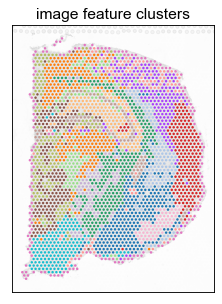

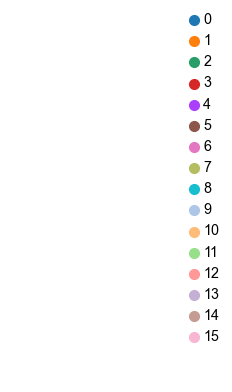

In [8]:
# plot feature clusters
fig, ax = plt.subplots(figsize=(3, 5))
sc.pl.spatial(
    adata,
    color='features_cluster',
    img_key='hires',
    ax=ax,
    alpha_img=0.2,
    bw=True,
    title='image feature clusters',
    #legend_loc=False,
    show=False
)
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# get legend colors to plot later
colors, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# save figure
plt.tight_layout()
plt.savefig('figures/hne/spatial_features_cluster.png', dpi=300, bbox_inches='tight')

# plot and save legend
labels = [' '.join(l.split('_')) for l in labels]

fig, ax1 = plt.subplots(1,1, figsize=(3,5))
plt.figlegend(colors, labels, frameon=False, markerscale=1.5)
ax1.axis('off')
plt.tight_layout()
plt.savefig('figures/hne/spatial_features_cluster_legend.png', dpi=300, bbox_inches='tight')
plt.show()

... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


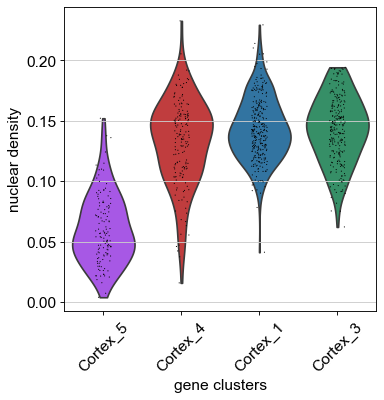

In [17]:
# violinplot of cell density in cortical areas
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.violin(sq.pl.extract(adata[adata.obs['cluster'].isin(['Cortex_5', 'Cortex_4', 'Cortex_1', 'Cortex_3'])],
              'features_segmentation'),
             keys='segmentation_feature_0', groupby='cluster', rotation=45,
             order=['Cortex_5', 'Cortex_4', 'Cortex_1', 'Cortex_3'],
            ylabel='nuclear density', xlabel='gene clusters', ax=ax, show=False)
#ax.set_title('Nuclear density in cortical clusters')
plt.savefig('figures/hne/celldensity_in_cortex_violin.png', dpi=300, bbox_inches='tight')

### Examination of cluster 12 - not in paper

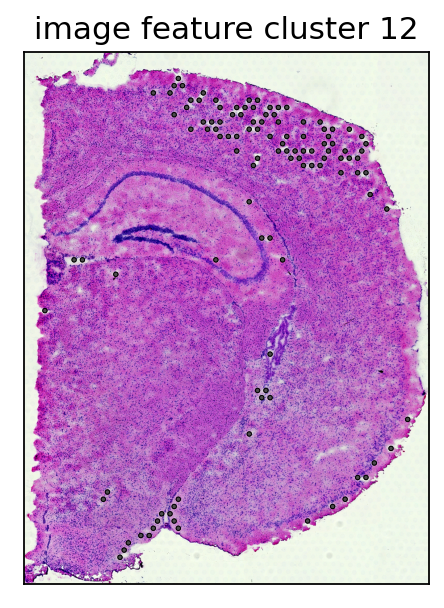

In [334]:
# subset to cluster 12 (holes in tissue) and plot
adata_sub = adata[adata.obs['features_cluster'].isin([12])]
fig, ax = plt.subplots(figsize=(3, 5))
sc.pl.spatial(
    adata_sub,
    img_key='hires',
    ax=ax,
    alpha_img=1,
    title='image feature cluster 12',
    #legend_loc=False,
    show=False,
    add_outline=True
)
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# get legend colors to plot later
colors, labels = ax.get_legend_handles_labels()
#ax.get_legend().remove()
# save figure
plt.tight_layout()
plt.savefig('figures/hne/spatial_features_cluster_12.png', dpi=300, bbox_inches='tight')


<ipython-input-343-b295a857f4a3> (2): 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
... storing 'features_cluster_12' as categorical


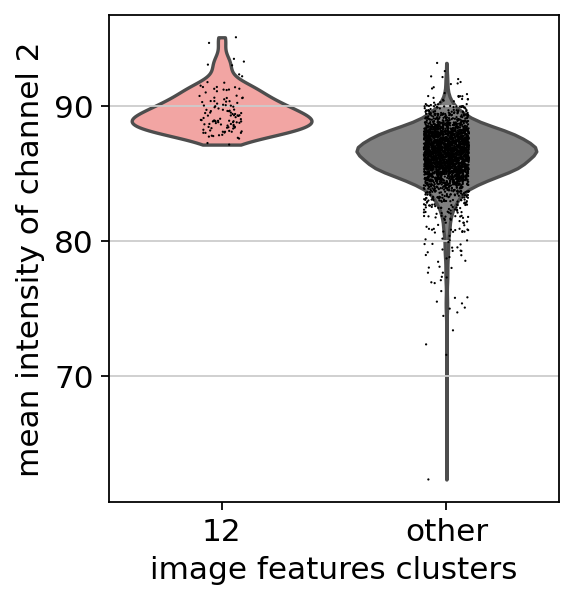

In [343]:
# TODO save as well!
adata.obs['features_cluster_12'] = np.array(adata.obs['features_cluster'].astype('str'))
adata.obs['features_cluster_12'][~adata.obs['features_cluster'].isin([12])] = 'other'
adata.uns['features_cluster_12_colors'] = list(np.array(adata.uns['features_cluster_colors'])[[12,]]) + ['#808080']
sc.pl.violin(sq.pl.extract(adata, 'features_orig'), keys=['summary_ch-2_mean'], groupby='features_cluster_12',
            xlabel='image features clusters', ylabel='mean intensity of channel 2')

### Examination of clusters 0,15 - for supplementary

<ipython-input-10-602c4e09bb14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cluster_sub'][~adata.obs['cluster'].isin(['Cortex_2', 'Cortex_5'])] = 'other'
<ipython-input-10-602c4e09bb14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['features_cluster_sub'][~adata.obs['features_cluster'].isin([0, 15])] = 'other'
... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


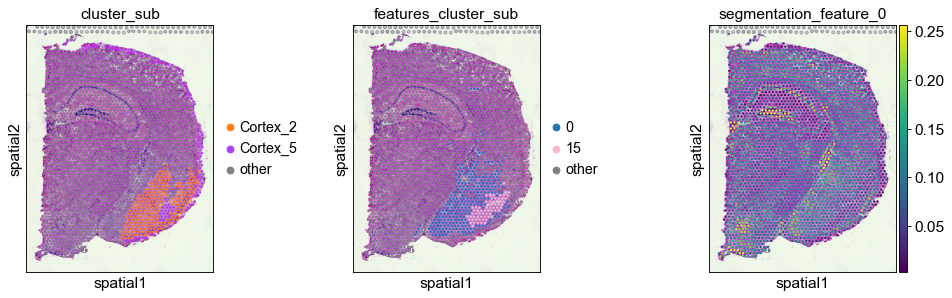

In [10]:
# visualise Cortex_2, Cortex_5 and corresponding feature clusters (low cell density cluster)
adata.obs['cluster_sub'] = np.array(adata.obs['cluster'])
adata.obs['cluster_sub'][~adata.obs['cluster'].isin(['Cortex_2', 'Cortex_5'])] = 'other'
#adata.obs['cluster_sub'][~adata.obs['features_cluster'].isin([0, 15])] = 'other'
adata.uns['cluster_sub_colors'] = list(adata.uns['cluster_colors'][[1, 4]]) + ['#808080']

adata.obs['features_cluster_sub'] = np.array(adata.obs['features_cluster'].astype('str'))
adata.obs['features_cluster_sub'][~adata.obs['features_cluster'].isin([0, 15])] = 'other'
adata.uns['features_cluster_sub_colors'] = list(np.array(adata.uns['features_cluster_colors'])[[0, 15]]) + ['#808080']

#adata_sub = adata[adata.obs['features_cluster'].isin(['0', '15'])]
sc.pl.spatial(sq.pl.extract(adata, 'features_segmentation'), color=['cluster_sub', 'features_cluster_sub', 'segmentation_feature_0'], vmax='p99')

... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


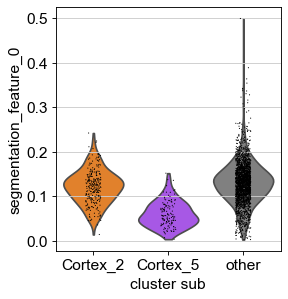

In [11]:
sc.pl.violin(sq.pl.extract(adata, 'features_segmentation'), keys=['segmentation_feature_0'], groupby='cluster_sub')

... storing 'cluster_sub' as categorical
... storing 'features_cluster_sub' as categorical


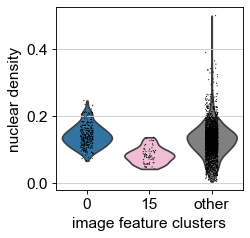

In [19]:
# violinplot of cell density in cortical areas
fig, ax = plt.subplots(1,1, figsize=(3,3))
sc.pl.violin(sq.pl.extract(adata, 'features_segmentation'), keys=['segmentation_feature_0'], groupby='features_cluster_sub', ylabel='nuclear density', xlabel='image feature clusters', ax=ax, show=False)
#ax.set_title('Nuclear density in cortical clusters')
plt.savefig('figures/hne/celldensity_in_feature_clusters_violin.png', dpi=300, bbox_inches='tight')

## Spatially variables genes

In [23]:
def plot_gene(adata, g, remove=None, vmax=None):
    # plot genes
    fig, ax = plt.subplots(figsize=(3, 5))
    sc.pl.spatial(
        adata,
        color=g,
        img_key='hires',
        ax=ax,
        alpha_img=0.2,
        bw=True,
        vmax=vmax,
        #legend_loc=False,
        show=False,
        cmap='viridis'
    )
    ax.axes.xaxis.label.set_visible(False)
    ax.axes.yaxis.label.set_visible(False)
    # remove one axis
    if remove == 'plot':
        fig.get_axes()[0].remove()
    elif remove == 'legend':
        fig.get_axes()[1].remove()
    return ax

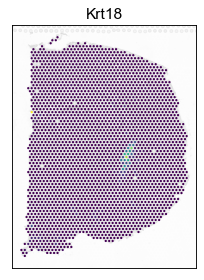

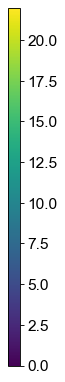

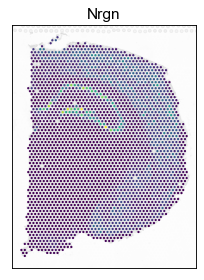

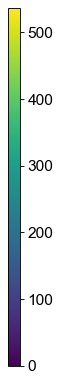

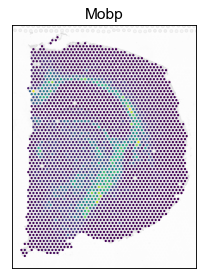

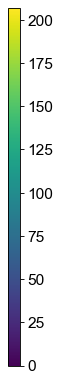

In [27]:
for g in ['Krt18', "Nrgn", "Mobp"]:
    # plot image
    ax = plot_gene(adata, g, remove='legend')
    plt.tight_layout()
    plt.savefig(f'figures/hne/spatial_{g}.png', dpi=300, bbox_inches='tight')

    # plot legend
    ax = plot_gene(adata, g, remove='plot')
    plt.tight_layout()
    plt.savefig(f'figures/hne/spatial_{g}_legend.png', dpi=300, bbox_inches='tight')

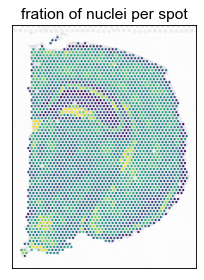

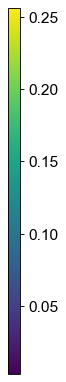

In [26]:
# plot number of cells
ax = plot_gene(sq.pl.extract(adata, 'features_segmentation'), 'segmentation_feature_0', remove='legend', vmax='p99')
ax.set_title('fration of nuclei per spot', fontdict={'fontsize': 14})
plt.tight_layout()
plt.savefig('figures/hne/spatial_features_celldensity.png', dpi=300, bbox_inches='tight')

# plot legend
ax = plot_gene(sq.pl.extract(adata, 'features_segmentation'), 'segmentation_feature_0', remove='plot', vmax='p99')
plt.tight_layout()
plt.savefig('figures/hne/spatial_features_celldensity_legend.png', dpi=300, bbox_inches='tight')

In [ ]:
# additional plot

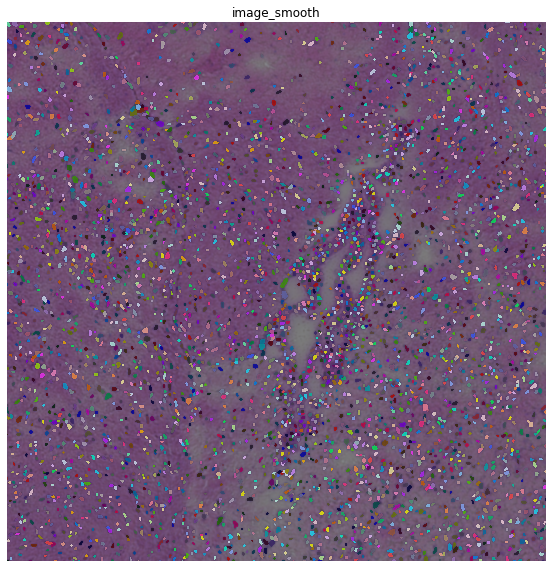

In [317]:
crop = img.crop_corner(5000, 5000, size=2000)
crop.show(layer='image_smooth', segmentation_layer='segmented_stardist')